In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_error
from scipy import stats
import seaborn as sns
from scipy import interpolate

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import add_changepoints_to_plot, plot_cross_validation_metric

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/My Drive/CMPE 255 Project/data/nooa_weather/nooa_nyc_weather_features.csv'
land_station_weather_features = pd.read_csv(path)
land_station_weather_features['Date'] = pd.to_datetime(land_station_weather_features['Date'], infer_datetime_format=True)
# Fills each column's null values with previous value
land_station_weather_features = land_station_weather_features.sort_values('Date').apply(lambda x: x[:x.last_valid_index()].ffill(), axis=0)
land_station_weather_features

,Date,TMAX,TMIN,PRCP,SNOW,AWND,SNWD,WDF2,WDF5,WSF2,WSF5
0,2015-01-01,39.0,-27.0,0.0,0.0,32.0,0.0,260.0,250.0,76.0,139.0
1,2015-01-02,56.0,17.0,0.0,0.0,32.0,0.0,260.0,310.0,67.0,112.0
2,2015-01-03,56.0,6.0,180.0,0.0,29.0,0.0,80.0,70.0,54.0,81.0
3,2015-01-04,133.0,50.0,76.0,0.0,29.0,0.0,280.0,260.0,130.0,206.0
4,2015-01-05,94.0,-60.0,0.0,0.0,47.0,0.0,280.0,300.0,107.0,170.0
...,...,...,...,...,...,...,...,...,...,...,...
2095,2020-09-26,233.0,183.0,0.0,0.0,12.0,0.0,250.0,230.0,40.0,85.0
2096,2020-09-27,261.0,194.0,8.0,0.0,12.0,0.0,250.0,230.0,40.0,85.0
2097,2020-09-28,250.0,206.0,5.0,0.0,12.0,0.0,250.0,230.0,40.0,85.0
2098,2020-09-29,233.0,194.0,119.0,0.0,12.0,0.0,250.0,230.0,40.0,85.0


In [ ]:
path = '/content/drive/My Drive/CMPE 255 Project/data/nooa_weather/nooa_lightning_data/agg_2011_2020_num_lightning_features.csv'
agg_nyc_lighting_count = pd.read_csv(path)
agg_nyc_lighting_count['Date'] = pd.to_datetime(agg_nyc_lighting_count['Date'], infer_datetime_format=True)
agg_nyc_lighting_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234 entries, 0 to 233
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          234 non-null    datetime64[ns]
 1   NumLightning  234 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 3.8 KB


In [ ]:
weather_features = land_station_weather_features.merge(agg_nyc_lighting_count, left_on='Date', right_on='Date', how='left').fillna(0)
weather_features

,Date,TMAX,TMIN,PRCP,SNOW,AWND,SNWD,WDF2,WDF5,WSF2,WSF5,NumLightning
0,2015-01-01,39.0,-27.0,0.0,0.0,32.0,0.0,260.0,250.0,76.0,139.0,0.0
1,2015-01-02,56.0,17.0,0.0,0.0,32.0,0.0,260.0,310.0,67.0,112.0,0.0
2,2015-01-03,56.0,6.0,180.0,0.0,29.0,0.0,80.0,70.0,54.0,81.0,0.0
3,2015-01-04,133.0,50.0,76.0,0.0,29.0,0.0,280.0,260.0,130.0,206.0,0.0
4,2015-01-05,94.0,-60.0,0.0,0.0,47.0,0.0,280.0,300.0,107.0,170.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2095,2020-09-26,233.0,183.0,0.0,0.0,12.0,0.0,250.0,230.0,40.0,85.0,0.0
2096,2020-09-27,261.0,194.0,8.0,0.0,12.0,0.0,250.0,230.0,40.0,85.0,0.0
2097,2020-09-28,250.0,206.0,5.0,0.0,12.0,0.0,250.0,230.0,40.0,85.0,0.0
2098,2020-09-29,233.0,194.0,119.0,0.0,12.0,0.0,250.0,230.0,40.0,85.0,0.0


# Ride Count Forecasting

In [ ]:
rides_tmp = []
years = range(2013, 2021)
for y in years:
  path = '/content/drive/My Drive/CMPE 255 Project/data/citibikes/rides_count_agg_{}.csv'.format(y)
  rides_y = pd.read_csv(path)
  rides_tmp.append(rides_y)

rides = pd.concat(rides_tmp)
rides['date'] = pd.to_datetime(rides['date'], infer_datetime_format=True)
rides = rides[rides.date < '2020-03-01'] # To remove COVID period because data may be unstable
rides

,date,usertype,numrides
0,2013-07-01,Customer,0
1,2013-07-01,Subscriber,13916
2,2013-07-02,Customer,2
3,2013-07-02,Subscriber,18672
4,2013-07-03,Customer,3
...,...,...,...
115,2020-02-27,Subscriber,40628
116,2020-02-28,Customer,1593
117,2020-02-28,Subscriber,39944
118,2020-02-29,Customer,1793


In [ ]:
rides = rides.merge(weather_features, left_on='date', right_on='Date').drop(['Date'], axis=1)
rides = rides.fillna(rides.mean())
rides

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.



,date,usertype,numrides,TMAX,TMIN,PRCP,SNOW,AWND,SNWD,WDF2,WDF5,WSF2,WSF5,NumLightning
0,2015-01-01,Customer,0,39.0,-27.0,0.0,0.0,32.0,0.0,260.0,250.0,76.0,139.0,0.0
1,2015-01-01,Subscriber,4651,39.0,-27.0,0.0,0.0,32.0,0.0,260.0,250.0,76.0,139.0,0.0
2,2015-01-02,Customer,0,56.0,17.0,0.0,0.0,32.0,0.0,260.0,310.0,67.0,112.0,0.0
3,2015-01-02,Subscriber,10662,56.0,17.0,0.0,0.0,32.0,0.0,260.0,310.0,67.0,112.0,0.0
4,2015-01-03,Customer,0,56.0,6.0,180.0,0.0,29.0,0.0,80.0,70.0,54.0,81.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3339,2020-02-27,Subscriber,40628,61.0,-5.0,102.0,0.0,57.0,0.0,280.0,290.0,125.0,197.0,0.0
3340,2020-02-28,Customer,1593,56.0,-16.0,0.0,0.0,44.0,0.0,270.0,230.0,94.0,152.0,0.0
3341,2020-02-28,Subscriber,39944,56.0,-16.0,0.0,0.0,44.0,0.0,270.0,230.0,94.0,152.0,0.0
3342,2020-02-29,Customer,1793,17.0,-38.0,0.0,0.0,39.0,0.0,300.0,330.0,81.0,134.0,0.0


In [ ]:
subscriber_rides = rides[rides['usertype'] == 'Subscriber']
subscriber_rides = subscriber_rides.rename(columns={'date':'ds', 'numrides':'y'})

customer_rides = rides[(rides['usertype'] == 'Customer') & (rides['date'] >= '2016-01-01')]
customer_rides = customer_rides.rename(columns={'date':'ds', 'numrides':'y'})

subscriber_rides

,ds,usertype,y,TMAX,TMIN,PRCP,SNOW,AWND,SNWD,WDF2,WDF5,WSF2,WSF5,NumLightning
1,2015-01-01,Subscriber,4651,39.0,-27.0,0.0,0.0,32.0,0.0,260.0,250.0,76.0,139.0,0.0
3,2015-01-02,Subscriber,10662,56.0,17.0,0.0,0.0,32.0,0.0,260.0,310.0,67.0,112.0,0.0
5,2015-01-03,Subscriber,4252,56.0,6.0,180.0,0.0,29.0,0.0,80.0,70.0,54.0,81.0,0.0
7,2015-01-04,Subscriber,7456,133.0,50.0,76.0,0.0,29.0,0.0,280.0,260.0,130.0,206.0,0.0
9,2015-01-05,Subscriber,14256,94.0,-60.0,0.0,0.0,47.0,0.0,280.0,300.0,107.0,170.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3335,2020-02-25,Subscriber,37032,117.0,78.0,36.0,0.0,17.0,0.0,60.0,220.0,54.0,76.0,0.0
3337,2020-02-26,Subscriber,42252,89.0,61.0,0.0,0.0,32.0,0.0,100.0,120.0,63.0,103.0,0.0
3339,2020-02-27,Subscriber,40628,61.0,-5.0,102.0,0.0,57.0,0.0,280.0,290.0,125.0,197.0,0.0
3341,2020-02-28,Subscriber,39944,56.0,-16.0,0.0,0.0,44.0,0.0,270.0,230.0,94.0,152.0,0.0


## Univariate Prophet without regressors (Subscribers)

In [ ]:
holdout_period = 365

max_date = subscriber_rides[['ds']].max()
split_date = max_date - timedelta(days=holdout_period)
split_date = split_date[0].strftime('%Y-%m-%d')
train = subscriber_rides.loc[subscriber_rides.ds <= split_date].copy()
test = subscriber_rides.loc[subscriber_rides.ds > split_date].copy()
print(split_date)

2019-03-01


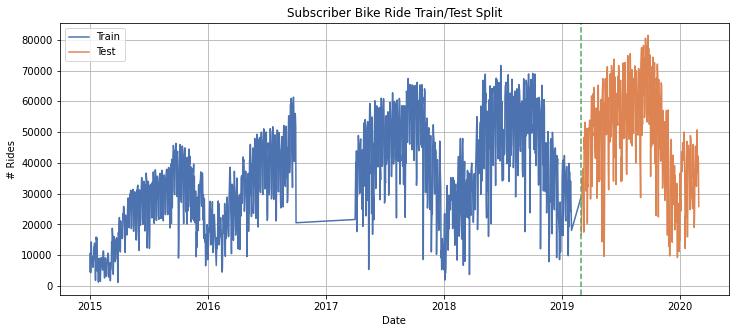

In [ ]:
sns_c = sns.color_palette(palette='deep')

fig, ax = plt.subplots(figsize=(12, 5))
sns.lineplot(x='ds', y='y', label='Train', data=train, ax=ax, color=sns_c[0])
sns.lineplot(x='ds', y='y', label='Test', data=test, ax=ax, color=sns_c[1])
ax.axvline(pd.to_datetime(split_date), color=sns_c[2], linestyle='--')
ax.legend(loc='upper left')
ax.grid(True)
ax.set(title='Subscriber Bike Ride Train/Test Split', xlabel='Date', ylabel='# Rides');

INFO:fbprophet:Making 9 forecasts with cutoffs between 2018-01-05 00:00:00 and 2018-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f1fc564eeb8>


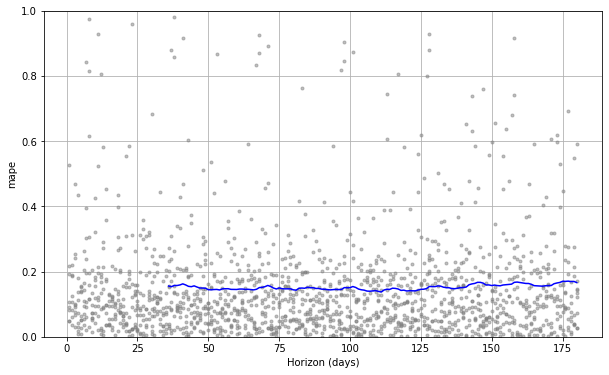

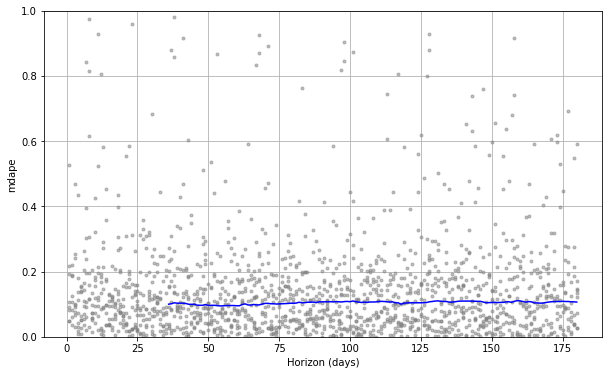

In [ ]:
# Cross Validation
# m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False, seasonality_mode='additive')
m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False, seasonality_mode='multiplicative')
m.add_country_holidays(country_name='US')

# Comment out below regressors to remove weather features from model training
m.add_regressor('TMAX', prior_scale=0.5)
m.add_regressor('TMIN', prior_scale=0.5)
m.add_regressor('SNOW', prior_scale=0.5)
m.add_regressor('PRCP', prior_scale=0.5)
m.add_regressor('AWND', prior_scale=0.5)
m.add_regressor('SNWD', prior_scale=0.5)
m.add_regressor('WDF2', prior_scale=0.5)
m.add_regressor('WDF5', prior_scale=0.5)
m.add_regressor('WSF2', prior_scale=0.5)
m.add_regressor('WSF5', prior_scale=0.5)
m.add_regressor('NumLightning', prior_scale=0.5)

m.fit(train)

df_cv = cross_validation(m, initial='1095 days', period='30 days', horizon='180 days', parallel='processes')

fig = plot_cross_validation_metric(df_cv, metric='mape', rolling_window=0.2)
plt.ylim(0, 1)
plt.show()

fig = plot_cross_validation_metric(df_cv, metric='mdape', rolling_window=0.2)
plt.ylim(0, 1)
plt.show()

In [ ]:
pm = performance_metrics(df_cv, rolling_window=0.2)
display(pm.head(), pm.tail())

,horizon,mse,rmse,mae,mape,mdape,coverage
0,36 days,4.302752e+07,6559.536892,5202.334061,0.155575,0.099985,0.590147
1,37 days,4.332834e+07,6582.426511,5200.377191,0.153753,0.101630,0.596436
2,38 days,4.722953e+07,6872.374130,5349.713668,0.157315,0.104267,0.590147
3,39 days,4.681193e+07,6841.924487,5371.804254,0.157274,0.103058,0.585954
4,40 days,4.704962e+07,6859.272498,5416.172843,0.159020,0.103058,0.579665


,horizon,mse,rmse,mae,mape,mdape,coverage
140,176 days,5.729330e+07,7569.234055,5886.286173,0.169912,0.108243,0.545423
141,177 days,5.669353e+07,7529.510925,5852.303260,0.170667,0.108243,0.546820
142,178 days,5.589264e+07,7476.137959,5789.056201,0.169256,0.107288,0.553459
143,179 days,5.659288e+07,7522.824055,5829.435052,0.169792,0.107288,0.554158
144,180 days,5.547943e+07,7448.451354,5783.678632,0.166340,0.106533,0.560797


In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true))

def median_absolute_percentage_error(y_true, y_pred): 
    return np.median(np.abs((y_true - y_pred) / y_true))

6261.731905205175
0.13647054266056352
0.10241044767762904


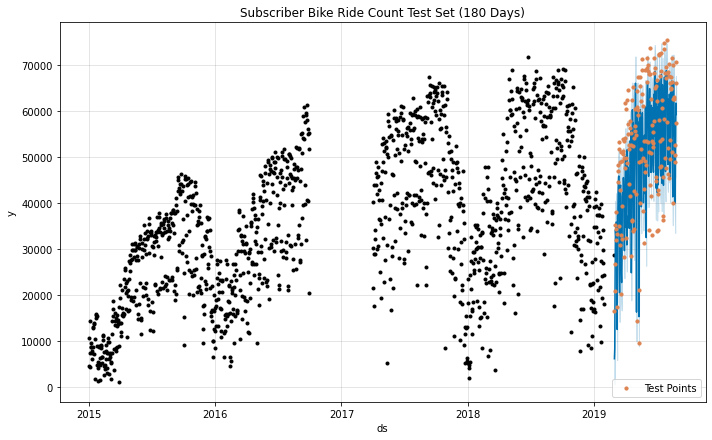

In [ ]:
forecast = m.predict(test[:180])
g = m.plot(forecast)
plt.scatter(test[:180]['ds'], test[:180]['y'], c=sns_c[1], s=10, zorder=10, label='Test Points')
plt.legend(loc='lower right')
plt.title('Subscriber Bike Ride Count Test Set (180 Days)')
forecast_test_period = forecast.loc[forecast.ds > split_date].merge(test[:180], left_on='ds', right_on='ds')
print(mean_absolute_error(forecast_test_period.y, forecast_test_period.yhat))
print(mean_absolute_percentage_error(forecast_test_period.y, forecast_test_period.yhat))
print(median_absolute_percentage_error(forecast_test_period.y, forecast_test_period.yhat))

5797.771634904966
0.1457471175281465
0.09842509977856258


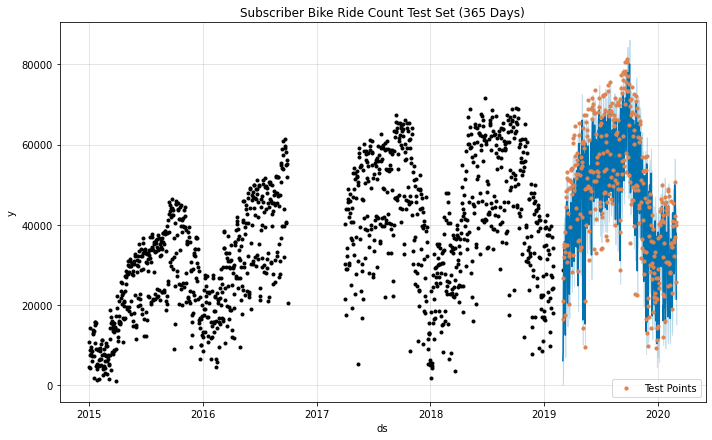

In [ ]:
forecast = m.predict(test)
g = m.plot(forecast)
plt.scatter(test['ds'], test['y'], c=sns_c[1], s=10, zorder=10, label='Test Points')
plt.legend(loc='lower right')
plt.title('Subscriber Bike Ride Count Test Set (365 Days)')

forecast_test_period = forecast.loc[forecast.ds > split_date].merge(test, left_on='ds', right_on='ds')
print(mean_absolute_error(forecast_test_period.y, forecast_test_period.yhat))
print(mean_absolute_percentage_error(forecast_test_period.y, forecast_test_period.yhat))
print(median_absolute_percentage_error(forecast_test_period.y, forecast_test_period.yhat))

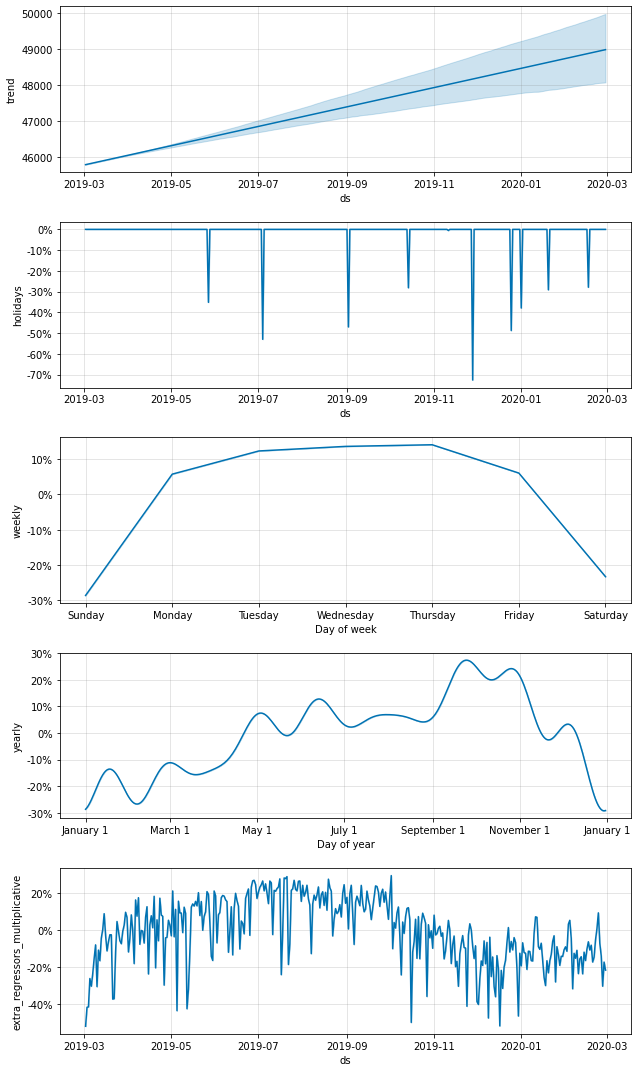

In [ ]:
g = m.plot_components(forecast)

## Univariate Prophet without regressors (Customers)

In [ ]:
holdout_period = 180

max_date = customer_rides[['ds']].max()
split_date = max_date - timedelta(days=holdout_period)
split_date = split_date[0].strftime('%Y-%m-%d')
train = customer_rides.loc[customer_rides.ds <= split_date].copy()
test = customer_rides.loc[customer_rides.ds > split_date].copy()
print(split_date)

2019-09-02


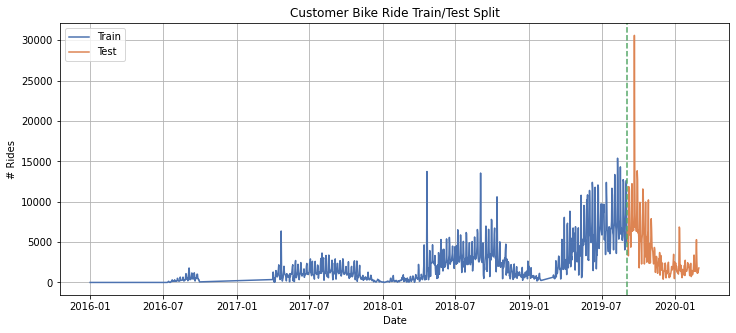

In [ ]:
sns_c = sns.color_palette(palette='deep')

fig, ax = plt.subplots(figsize=(12, 5))
sns.lineplot(x='ds', y='y', label='Train', data=train, ax=ax, color=sns_c[0])
sns.lineplot(x='ds', y='y', label='Test', data=test, ax=ax, color=sns_c[1])
ax.axvline(pd.to_datetime(split_date), color=sns_c[2], linestyle='--')
ax.legend(loc='upper left')
ax.grid(True)
ax.set(title='Customer Bike Ride Train/Test Split', xlabel='Date', ylabel='# Rides');

INFO:fbprophet:Making 5 forecasts with cutoffs between 2019-01-05 00:00:00 and 2019-03-06 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f9db4b60710>


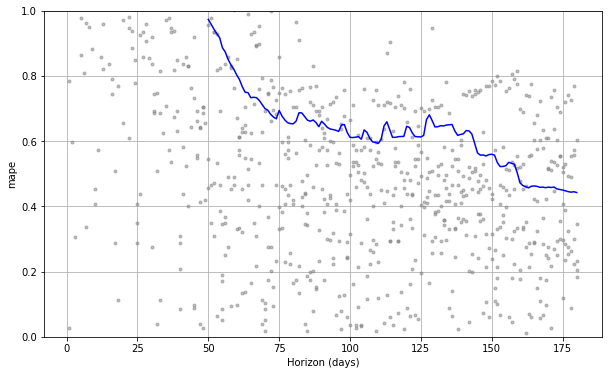

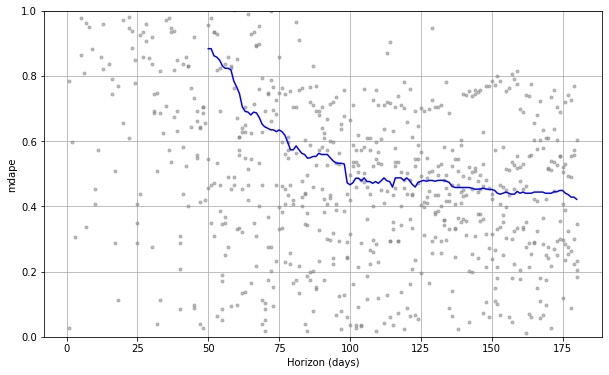

In [ ]:
# Cross Validation

m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False, seasonality_mode='multiplicative')
m.add_country_holidays(country_name='US')
m.fit(train)

df_cv = cross_validation(m, initial='1095 days', period='15 days', horizon='180 days', parallel='processes')

fig = plot_cross_validation_metric(df_cv, metric='mape', rolling_window=0.2)
plt.ylim(0, 1)
plt.show()

fig = plot_cross_validation_metric(df_cv, metric='mdape', rolling_window=0.2)
plt.ylim(0, 1)
plt.show()

1815.7574305216326
0.6003915346197624
0.2318295880963533


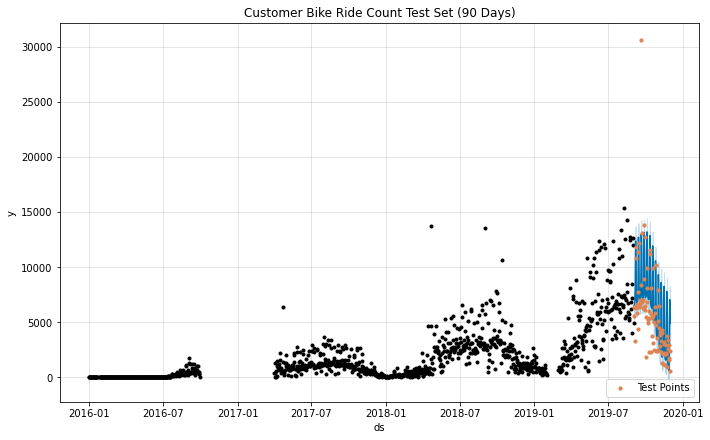

In [ ]:
forecast = m.predict(test[:90])
g = m.plot(forecast)
plt.scatter(test[:90]['ds'], test[:90]['y'], c=sns_c[1], s=10, zorder=10, label='Test Points')
plt.legend(loc='lower right')
plt.title('Customer Bike Ride Count Test Set (90 Days)')
forecast_test_period = forecast.loc[forecast.ds > split_date].merge(test[:180], left_on='ds', right_on='ds')
print(mean_absolute_error(forecast_test_period.y, forecast_test_period.yhat))
print(mean_absolute_percentage_error(forecast_test_period.y, forecast_test_period.yhat))
print(median_absolute_percentage_error(forecast_test_period.y, forecast_test_period.yhat))

1948.841471385065
0.999476626389716
0.5941128917800674


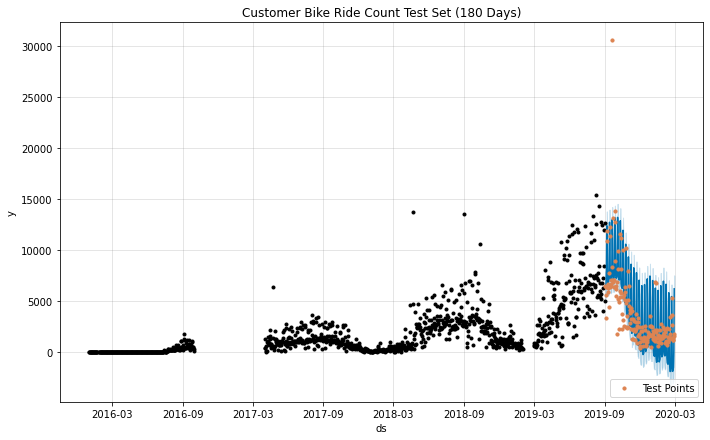

In [ ]:
forecast = m.predict(test)
g = m.plot(forecast)
plt.scatter(test['ds'], test['y'], c=sns_c[1], s=10, zorder=10, label='Test Points')
plt.legend(loc='lower right')
plt.title('Customer Bike Ride Count Test Set (180 Days)')

forecast_test_period = forecast.loc[forecast.ds > split_date].merge(test, left_on='ds', right_on='ds')
print(mean_absolute_error(forecast_test_period.y, forecast_test_period.yhat))
print(mean_absolute_percentage_error(forecast_test_period.y, forecast_test_period.yhat))
print(median_absolute_percentage_error(forecast_test_period.y, forecast_test_period.yhat))

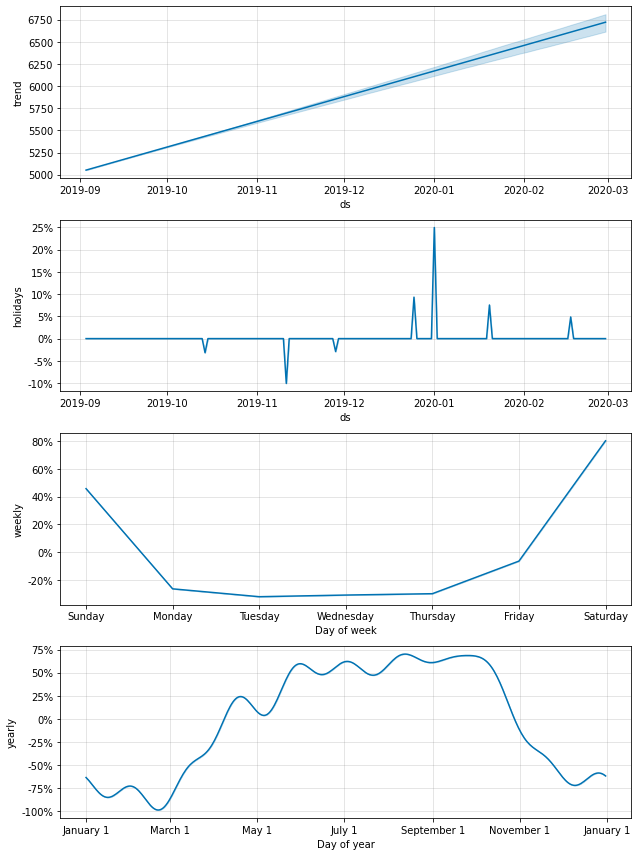

In [ ]:
g = m.plot_components(forecast)

# Bike Accident Forecasting

In [ ]:
path = '/content/drive/My Drive/CMPE 255 Project/data/bike_accidents/accident_count_agg.csv'
num_bike_collisions = pd.read_csv(path)
num_bike_collisions['date'] = pd.to_datetime(num_bike_collisions['date'], infer_datetime_format=True)
num_bike_collisions

,date,num_crashes
0,2016-03-08,2
1,2016-03-09,1
2,2016-03-11,1
3,2016-03-12,2
4,2016-03-13,5
...,...,...
1674,2020-10-09,27
1675,2020-10-10,13
1676,2020-10-11,17
1677,2020-10-12,13


In [ ]:
num_bike_collisions = num_bike_collisions.merge(weather_features, left_on='date', right_on='Date').drop(['Date'], axis=1)
num_bike_collisions = num_bike_collisions.fillna(num_bike_collisions.mean())
num_bike_collisions = num_bike_collisions.rename(columns={'date':'ds', 'num_crashes':'y'})
num_bike_collisions

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.



,ds,y,TMAX,TMIN,PRCP,SNOW,AWND,SNWD,WDF2,WDF5,WSF2,WSF5
0,2016-03-08,2,194.0,83.0,0.0,0.0,15.00000,0.0,170.000000,170.000000,63.00000,85.000000
1,2016-03-09,1,250.0,67.0,0.0,0.0,10.00000,0.0,240.000000,210.000000,45.00000,98.000000
2,2016-03-11,1,200.0,89.0,15.0,0.0,27.00000,0.0,40.000000,10.000000,76.00000,116.000000
3,2016-03-12,2,150.0,44.0,0.0,0.0,23.00000,0.0,250.000000,250.000000,67.00000,103.000000
4,2016-03-13,5,167.0,100.0,0.0,0.0,16.00000,0.0,30.000000,30.000000,54.00000,81.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
1662,2020-09-27,31,261.0,194.0,8.0,0.0,22.07978,0.0,191.894231,194.937111,60.57761,98.586731
1663,2020-09-28,23,250.0,206.0,5.0,0.0,22.07978,0.0,191.894231,194.937111,60.57761,98.586731
1664,2020-09-29,21,233.0,194.0,119.0,0.0,22.07978,0.0,191.894231,194.937111,60.57761,98.586731
1665,2020-09-30,27,217.0,156.0,290.0,0.0,28.00000,0.0,270.000000,160.000000,76.00000,121.000000


In [ ]:
holdout_period = 365

max_date = num_bike_collisions[['ds']].max()
split_date = max_date - timedelta(days=holdout_period)
split_date = split_date[0].strftime('%Y-%m-%d')
train = num_bike_collisions.loc[num_bike_collisions.ds <= split_date].copy()
test = num_bike_collisions.loc[num_bike_collisions.ds > split_date].copy()
print(split_date)

2019-10-02


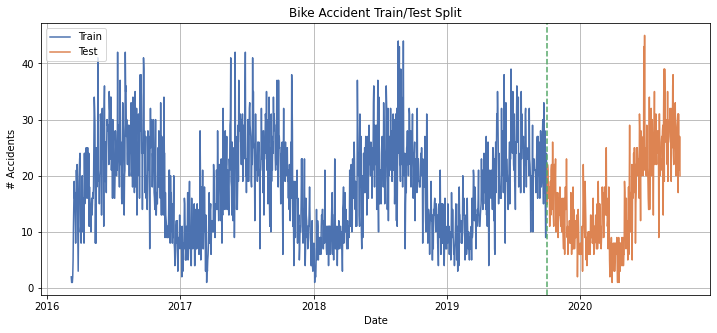

In [ ]:
sns_c = sns.color_palette(palette='deep')

fig, ax = plt.subplots(figsize=(12, 5))
sns.lineplot(x='ds', y='y', label='Train', data=train, ax=ax, color=sns_c[0])
sns.lineplot(x='ds', y='y', label='Test', data=test, ax=ax, color=sns_c[1])
ax.axvline(pd.to_datetime(split_date), color=sns_c[2], linestyle='--')
ax.legend(loc='upper left')
ax.grid(True)
ax.set(title='Bike Accident Train/Test Split', xlabel='Date', ylabel='# Accidents');

INFO:fbprophet:Making 14 forecasts with cutoffs between 2018-03-11 00:00:00 and 2019-04-05 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f80b05c9e10>


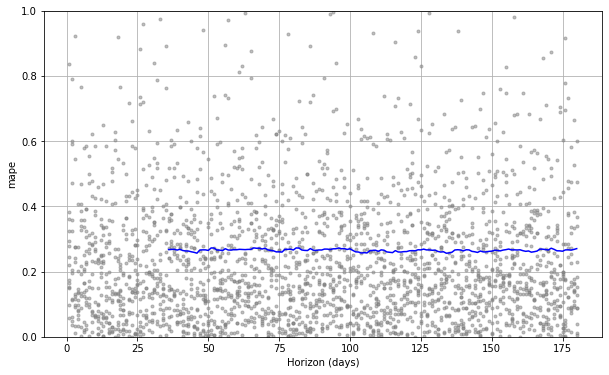

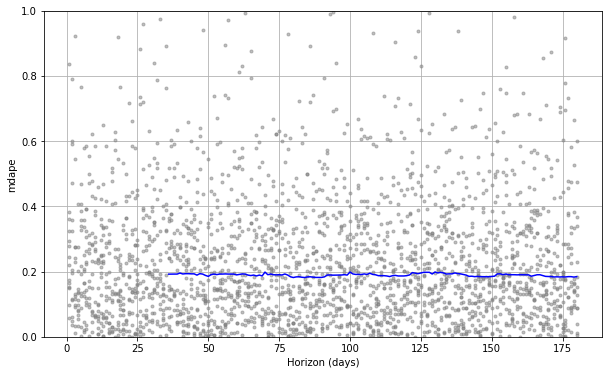

In [ ]:
# Cross Validation
m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False, seasonality_mode='additive')
# m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False, seasonality_mode='multiplicative')
m.add_country_holidays(country_name='US')

# Comment out below regressors to remove weather features from model training
m.add_regressor('TMAX', prior_scale=0.5)
m.add_regressor('TMIN', prior_scale=0.5)
m.add_regressor('SNOW', prior_scale=0.5)
m.add_regressor('PRCP', prior_scale=0.5)
m.add_regressor('AWND', prior_scale=0.5)
m.add_regressor('SNWD', prior_scale=0.5)
m.add_regressor('WDF2', prior_scale=0.5)
m.add_regressor('WDF5', prior_scale=0.5)
m.add_regressor('WSF2', prior_scale=0.5)
m.add_regressor('WSF5', prior_scale=0.5)
m.add_regressor('NumLightning', prior_scale=0.5)

m.fit(train)

df_cv = cross_validation(m, initial='730 days', period='30 days', horizon='180 days', parallel='processes')

fig = plot_cross_validation_metric(df_cv, metric='mape', rolling_window=0.2)
plt.ylim(0, 1)
plt.show()

fig = plot_cross_validation_metric(df_cv, metric='mdape', rolling_window=0.2)
plt.ylim(0, 1)
plt.show()

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true))

def median_absolute_percentage_error(y_true, y_pred): 
    return np.median(np.abs((y_true - y_pred) / y_true))

3.4883287382364503
0.3655582074396355
0.2697780800523842


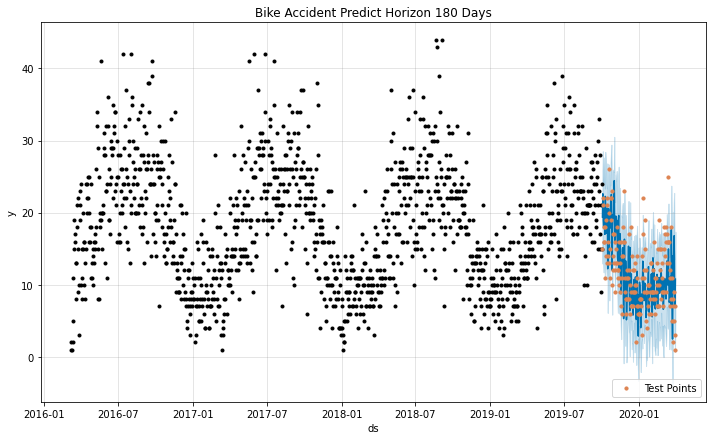

In [ ]:
forecast = m.predict(test[:180])
g = m.plot(forecast)
plt.scatter(test[:180]['ds'], test[:180]['y'], c=sns_c[1], s=10, zorder=10, label='Test Points')
plt.legend(loc='lower right')
plt.title('Bike Accident Predict Horizon 180 Days')
forecast_test_period = forecast.loc[forecast.ds > split_date].merge(test[:180], left_on='ds', right_on='ds')
print(mean_absolute_error(forecast_test_period.y, forecast_test_period.yhat))
print(mean_absolute_percentage_error(forecast_test_period.y, forecast_test_period.yhat))
print(median_absolute_percentage_error(forecast_test_period.y, forecast_test_period.yhat))

4.686780725545035
0.48961824703056445
0.23886591257485162


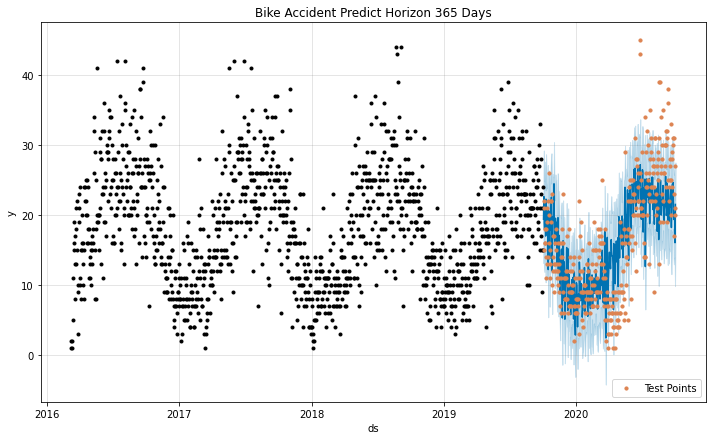

In [ ]:
forecast = m.predict(test)
g = m.plot(forecast)
plt.scatter(test['ds'], test['y'], c=sns_c[1], s=10, zorder=10, label='Test Points')
plt.legend(loc='lower right')
plt.title('Bike Accident Predict Horizon 365 Days')

forecast_test_period = forecast.loc[forecast.ds > split_date].merge(test, left_on='ds', right_on='ds')
print(mean_absolute_error(forecast_test_period.y, forecast_test_period.yhat))
print(mean_absolute_percentage_error(forecast_test_period.y, forecast_test_period.yhat))
print(median_absolute_percentage_error(forecast_test_period.y, forecast_test_period.yhat))

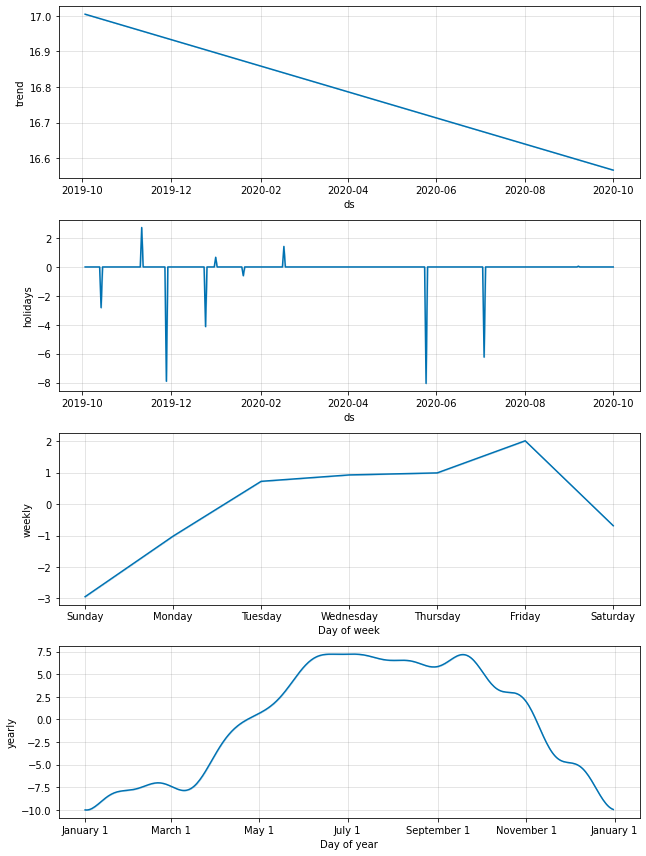

In [ ]:
g = m.plot_components(forecast)